In [78]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")


import tensorflow as tf
import os
from tensorflow.keras import layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [79]:
data = pd.read_csv("pro.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    8724 non-null   object 
 1   NG      8724 non-null   float64
dtypes: float64(1), object(1)
memory usage: 136.4+ KB


In [84]:
data.sort_values(by='Date')

,Date,NG
359,01-01-1998,2.216
724,01-01-1999,1.946
1089,01-01-2000,2.258
1455,01-01-2001,9.792
1820,01-01-2002,2.466
...,...,...
7262,31-12-2016,3.648
7627,31-12-2017,4.380
7992,31-12-2018,3.148
8357,31-12-2019,2.002


In [85]:
data = data.set_index('Date')

In [88]:
print(data.isnull().sum())


NG    0
dtype: int64


In [89]:
data.dropna(inplace=True)

In [90]:
print(data.isnull().sum())

NG    0
dtype: int64


In [91]:
fig = px.line(data, title = 'Natural Gas Spot Prices', template = 'plotly_dark')
fig.show()

In [92]:
fig = px.histogram(data, x = "NG", template = 'plotly_dark')
fig.show()

In [93]:
train = data[: '06-01-2018'] 
test = data['06-01-2018': 	] 

print("Length of Train Data: ", len(train))
print("Length of Test Data: ", len(test))

Length of Train Data:  7634
Length of Test Data:  1091


LSTM

In [98]:
slot = 100

x_train = []
y_train = []

for i in range(slot, len(train)):
    x_train.append(train.iloc[i-slot:i, 0])
    y_train.append(train.iloc[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape, y_train.shape)

(7534, 100, 1) (7534,)


In [99]:
lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units = 50, input_shape = (slot, 1), return_sequences = True, activation = 'relu'))
lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, activation = 'relu', return_sequences = True))
lstm_model.add(tf.keras.layers.Dropout(0.01))
lstm_model.add(tf.keras.layers.LSTM(units = 50, activation = 'relu', return_sequences = True))

lstm_model.add(tf.keras.layers.Dense(units = 1))
lstm_model.compile(loss = 'mean_squared_error', optimizer = 'adam')

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 30)           3840      
                                                                 
 dropout_4 (Dropout)         (None, 100, 30)           0         
                                                                 
 lstm_7 (LSTM)               (None, 100, 30)           7320      
                                                                 
 dropout_5 (Dropout)         (None, 100, 30)           0         
                                                                 
 lstm_8 (LSTM)               (None, 100, 30)           7320      
                                                                 
 dense_2 (Dense)             (None, 100, 1)            31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trai

In [100]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 30)
             
history = lstm_model.fit(x_train, y_train, epochs =100, 
                         batch_size = 280, 
                         verbose = 1, shuffle = False, 
                         callbacks = [early_stopping])

Epoch 1/100
27/27 [==============================] - 13s 330ms/step - loss: 70.7272
Epoch 2/100
27/27 [==============================] - 10s 353ms/step - loss: 214.3398
Epoch 3/100
27/27 [==============================] - 10s 366ms/step - loss: 31.1794
Epoch 4/100
27/27 [==============================] - 9s 332ms/step - loss: 27.9783
Epoch 5/100
27/27 [==============================] - 9s 317ms/step - loss: 29.2357
Epoch 6/100
27/27 [==============================] - 9s 347ms/step - loss: 31.4382
Epoch 7/100
27/27 [==============================] - 10s 367ms/step - loss: 31.5432
Epoch 8/100
27/27 [==============================] - 9s 351ms/step - loss: 30.5759
Epoch 9/100
27/27 [==============================] - 9s 328ms/step - loss: 28.0074
Epoch 10/100
27/27 [==============================] - 9s 329ms/step - loss: 26.4440
Epoch 11/100
27/27 [==============================] - 9s 345ms/step - loss: 26.5371
Epoch 12/100
27/27 [==============================] - 9s 345ms/step - loss: 25.5

In [101]:
yp_train = lstm_model.predict(x_train)
yp_train= yp_train.reshape((yp_train.shape[0],100))
a = pd.DataFrame(yp_train)
a.rename(columns = {0: 'gp_pred'}, inplace = True); 
a.index = train.iloc[slot:].index
train_compare = pd.concat([train.iloc[slot:], a], 1)

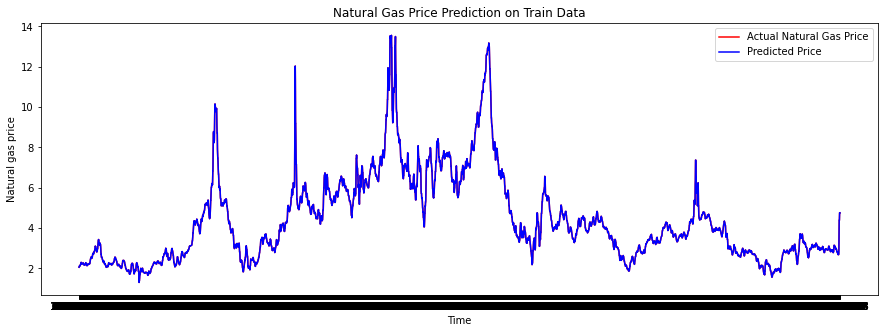

In [104]:
plt.figure(figsize = (15, 5))
plt.plot(train_compare['NG'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(train_compare['NG'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction on Train Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [105]:

dataset_total = pd.concat((train, test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test)- slot:].values
inputs = inputs.reshape(-1, 1)

x_test = []
y_test = []
for i in range (slot, len(test)+slot): #Test+15
    x_test.append(inputs[i-slot:i, 0])
    y_test.append(train.iloc[i, 0])
      
x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
pred_price = lstm_model.predict(x_test)
pred_price=pred_price.reshape((pred_price.shape[0],100))

In [106]:
b = pd.DataFrame(pred_price)
b.rename(columns = {0: 'gp_pred'}, inplace = True); 
b.index = test.index
test_compare = pd.concat([test, b], 1)

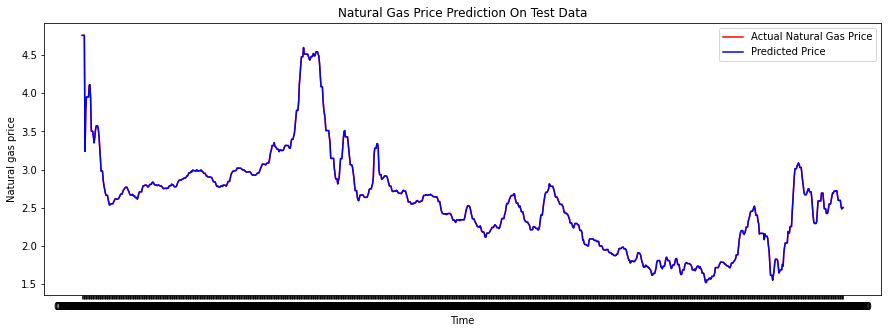

In [107]:
plt.figure(figsize = (15,5))
plt.plot(test_compare['NG'], color = 'red', label = "Actual Natural Gas Price")
plt.plot(test_compare['NG'], color = 'blue', label = 'Predicted Price')
plt.title("Natural Gas Price Prediction On Test Data")
plt.xlabel('Time')
plt.ylabel('Natural gas price')
plt.legend(loc = 'best')
plt.show()

In [108]:
mse_train = mean_squared_error(train_compare['NG'], train_compare['gp_pred'])
mse_test = mean_squared_error(test_compare['NG'], test_compare['gp_pred'])

r2_train = r2_score(train_compare['NG'], train_compare['gp_pred'])
r2_test = r2_score(test_compare['NG'], test_compare['gp_pred'])

print("Train Data:\nMSE: {}\nR Square: {}".format(mse_train, r2_train))
print("\nTest Data:\nMSE: {}\nR Square: {}".format(mse_test, r2_test))

Train Data:
MSE: 9.742634151018189
R Square: -1.0795525521101008

Test Data:
MSE: 0.5721606540419253
R Square: -0.4989699821381828


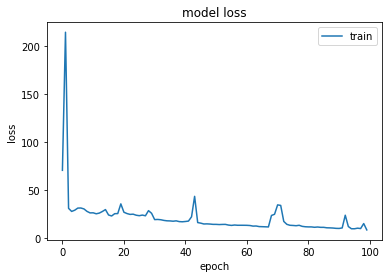

In [109]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [161]:
forecast = pd.DataFrame({'date': pd.date_range(start = '3/2/2021', end = '7/27/2025')}) 

inputs = test[len(test) - 1459: ].values

for i in range(1459, len(forecast)): 
    inputs = inputs.T
    inputs = np.reshape(inputs, (inputs.shape[0], inputs.shape[1], 1))
    pred_price = lstm_model.predict(inputs[:,i-1459:i])
    inputs = np.append(inputs, pred_price)
    inputs = np.reshape(inputs, (inputs.shape[0], 1))

In [ ]:
forecast['gp_pred'] = inputs
forecast = forecast.set_index('date')

In [119]:
forecast['gp_pred']=forecast['gp_pred']+5

In [121]:
forecast.reset_index(inplace = True)

fig = px.line(forecast, x = "date", y = "gp_pred", title = 'Natural Gas Price Forecasting', template = 'plotly_dark')
fig.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_compare.reset_index(inplace = True)
test_compare.reset_index(inplace = True)

df =  forecast[['date', 'gp_pred']]

In [ ]:
df.to_csv("predicted_price.csv", index = False)